# Application of GCN on HGCAL data

## Importing the required packages

In [1]:
#General packages
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

#Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

#Packages for GNN
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
#from torch_geometric.nn import GCNConv, global_add_pool
from sklearn.neighbors import NearestNeighbors

## ROOT ---> Numpy arrays

In [2]:
file=uproot.open("ntuple_pi+_100GeV_100keve.root:AllLayers")
branches=["hit_x","hit_y","hit_z","hit_l","hit_E"]
events=file.arrays(branches,library="ak")

In [3]:
#events  ### Awkawrd array in Dictionary like format
#type(events)
#events.hit_x # Returns the awkard arrays for the hit_x for all events

In [4]:
#events[0].hit_x # Returns the hit_x data for the first event, as numpy arrays

## Preparing the Dataset

In [104]:
#Defining the root files and their path names
particle_files={
    "pi+":"ntuple_pi+_100GeV_100keve.root:AllLayers",
    "e+":"ntuple_e+_100_GeV_100Keve.root:AllLayers",
    "Y":"ntuple_gamma_100GeV_25keve_p1.root:AllLayers",
    "K-":"ntuple_kaon-_100GeV_20keve_p1.root:AllLayers",
    "K+":"ntuple_kaon+_100GeV_20keve_p1.root:AllLayers",
    "K_0":"ntuple_kaon0L_100GeV_10keve_test.root:AllLayers",
    "mu+":"ntuple_mu+_100GeV_100keve.root:AllLayers",
    "n":"ntuple_neutron_100GeV_10keve_test.root:AllLayers",
    "p":"ntuple_proton_100GeV_20keve_p1.root:AllLayers"
}
particle_ids={
    "pi+":0,
    "e+":1,
    "Y":2,
    "K-":4,
    "K+":5,
    "K_0":6,
    "mu+":7,
    "n":8,
    "p":9
}


In [105]:
#Defining the root files and their path names
particle_files={
    "pi+":"ntuple_pi+_100GeV_100keve.root:AllLayers",
    "e+":"ntuple_e+_100_GeV_100Keve.root:AllLayers",
    "Y":"ntuple_gamma_100GeV_25keve_p1.root:AllLayers",
    
}
particle_ids={
    "pi+":0,
    "e+":1,
    "Y":2
}


In [106]:
branches=["hit_x","hit_y","hit_z","hit_l","hit_E"]
all_events=[]
all_labels=[]

for pname,file_path in particle_files.items():
    file=uproot.open(file_path)
    events=file.arrays(branches,library="ak")[:1000] #Only 5000 events for now
    #Assigning particle ids
    pid=particle_ids[pname]
    #Store everything as a tuple
    all_events.extend([(events[i],pid) for i in range(len(events))])

In [114]:
#Shuffling
from sklearn.utils import shuffle
all_events=shuffle(all_events,random_state=28)

## Creating the event graphs

In [115]:
def create_graph(event,k=8):
    x=ak.to_numpy(event.hit_x)
    y=ak.to_numpy(event.hit_y)
    z=ak.to_numpy(event.hit_z)
    l=ak.to_numpy(event.hit_l)
    E=ak.to_numpy(event.hit_E)
    #Removing zero energy hits
    mask_E=E>0
    x,y,z,l,E=x[mask_E],y[mask_E],z[mask_E],l[mask_E],E[mask_E]
    coords=np.column_stack((x,y,z))
    N=len(coords)
    if N<k+1:
        return None
    
    #Node features
    node_features=torch.from_numpy(np.column_stack((x,y,z,l,E))).float()

    #Global KNN
    knn=NearestNeighbors(n_neighbors=k+1,algorithm="kd_tree").fit(coords)
    knn_dist,knn_idx=knn.kneighbors(coords)
    knn_idx=knn_idx[:,1:] #Removes the self hit
    #print(knn_dist[9,:],knn_idx[9,:])

    #Edge construction
    src=np.repeat(np.arange(N),k)
    dst=knn_idx.reshape(-1)
    mask=dst>=0
    src,dst=src[mask],dst[mask]
    edge_index=torch.tensor(np.vstack([src,dst]),dtype=torch.long)

    #Edge attributes
    edge_attr = torch.tensor((E[src] * E[dst]).reshape(-1, 1),dtype=torch.float)

    #Final creation
    graph= Data(x=node_features,edge_index=edge_index,edge_attr=edge_attr)
    return graph

In [116]:
#graph=[create_graph(event,k=8) for event in events]    

In [117]:
#creating graphs for all events
graph=[]
for event,pid in all_events:
    g=create_graph(event,k=8)
    if g is not None:
        g.y=torch.tensor([pid],dtype=torch.long)
        graph.append(g)

In [118]:
#Debugging-1
for g in graph[:20]:
    print(g.y.item())

0
1
1
1
1
2
1
1
0
2
2
0
2
1
2
2
2
0
1
0


In [121]:
#Debugging-2
g = graph[3]
print(g.y)
print(g.y.shape)


tensor([1])
torch.Size([1])


In [122]:
graph[:20]

[Data(x=[331, 5], edge_index=[2, 2648], edge_attr=[2648, 1], y=[1]),
 Data(x=[693, 5], edge_index=[2, 5544], edge_attr=[5544, 1], y=[1]),
 Data(x=[666, 5], edge_index=[2, 5328], edge_attr=[5328, 1], y=[1]),
 Data(x=[743, 5], edge_index=[2, 5944], edge_attr=[5944, 1], y=[1]),
 Data(x=[746, 5], edge_index=[2, 5968], edge_attr=[5968, 1], y=[1]),
 Data(x=[678, 5], edge_index=[2, 5424], edge_attr=[5424, 1], y=[1]),
 Data(x=[721, 5], edge_index=[2, 5768], edge_attr=[5768, 1], y=[1]),
 Data(x=[703, 5], edge_index=[2, 5624], edge_attr=[5624, 1], y=[1]),
 Data(x=[450, 5], edge_index=[2, 3600], edge_attr=[3600, 1], y=[1]),
 Data(x=[687, 5], edge_index=[2, 5496], edge_attr=[5496, 1], y=[1]),
 Data(x=[673, 5], edge_index=[2, 5384], edge_attr=[5384, 1], y=[1]),
 Data(x=[468, 5], edge_index=[2, 3744], edge_attr=[3744, 1], y=[1]),
 Data(x=[679, 5], edge_index=[2, 5432], edge_attr=[5432, 1], y=[1]),
 Data(x=[704, 5], edge_index=[2, 5632], edge_attr=[5632, 1], y=[1]),
 Data(x=[738, 5], edge_index=[2, 5

## Splitting into training and testing

In [123]:
from sklearn.model_selection import train_test_split

#First split: Train vs Temp(Val+Test)
train_data, temp_data= train_test_split(graph, test_size=0.3, random_state=42)

#Second split: Test vs Val
val_data, test_data= train_test_split(temp_data, test_size=0.7, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 2100
Validation samples: 270
Test samples: 630


## Using DataLoader

In [124]:
from torch_geometric.loader import DataLoader
batch_size=64

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Making the GCN

### Developing the Message Passing Block

In [125]:
#Making the message passing network
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
class GCNConv(MessagePassing):
    def __init__(self,in_channels,out_channels):
        #Here, in_channels: Input node features
        super().__init__(aggr='add')
        self.lin=Linear(in_channels,out_channels,bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()
        
    def forward(self,x,edge_index):
        # x has the shape [No. of hits, in_channels]
        #edge_index has shape [2, No. of edges]
        #Step-1: Add self loops
        edge_index,_=add_self_loops(edge_index,num_nodes=x.size(0))
        #Step-2: Linearly transform node feature matrix
        x=self.lin(x)
        #Step-3: Compute Normalization
        row,col=edge_index
        deg=degree(col,x.size(0))
        deg_inv_sqr=deg.pow(-0.5)
        deg_inv_sqr[deg_inv_sqr==float('inf')]=0
        norm=deg_inv_sqr[row]*deg_inv_sqr[col]
        #Step-4-5: Propagating the message- Normalize the node features and then add
        out=self.propagate(edge_index,x=x,norm=norm)
        #Step 6: Apply the end bias vector
        out=out+self.bias
        
        return out
    
    def message(self, x_j, norm):
        return norm.view(-1,1)*x_j

### Stacking the GNN layers for 'Convolution'

In [126]:
import torch
from torch import nn
import torch.nn.functional as F
#from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN_Event_Classifier(nn.Module):
    def __init__(self, input_dim,hidden_dim,output_dim):
        super().__init__()
        #The GCN Layers
        self.conv1=GCNConv(input_dim,hidden_dim)
        self.conv2=GCNConv(hidden_dim,hidden_dim)
        self.conv3=GCNConv(hidden_dim,hidden_dim)
        #Regularization
        self.dropout=nn.Dropout(p=0.1)
        #Output- MLP- mainly doing the classification task.
        self.output=nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )
        
    def forward(self,data):
        #x,edge_index=data.x, data.edge_index
        x,edge_index,batch=data.x,data.edge_index,data.batch
        #First GCN Block
        x=self.conv1(x,edge_index)
        x=F.relu(x)
        x=self.dropout(x)
        #Second GCN block
        x=self.conv2(x,edge_index)
        x=F.relu(x)
        x=self.dropout(x)
        #Third GCN block
        x=self.conv3(x,edge_index)
        x=F.relu(x)
        x=self.dropout(x)
        
        #Saving the node embeddings
        node_embedding=x
        
        #Global pooling
        event_embedding=global_mean_pool(x,batch)
        #Node-level-predictions
        out=self.output(event_embedding)
        
        return out,node_embedding

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [134]:
model=GCN_Event_Classifier(input_dim=5,hidden_dim=64,output_dim=3).to(device)

In [135]:
model

GCN_Event_Classifier(
  (conv1): GCNConv()
  (conv2): GCNConv()
  (conv3): GCNConv()
  (dropout): Dropout(p=0.1, inplace=False)
  (output): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)

### Developing the training, validation and testing loops

In [136]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
criterion=torch.nn.CrossEntropyLoss()

In [140]:
#Training loop
def train():
    model.train()
    total_loss=0.0
    for batch in train_loader:
        batch=batch.to(device)
        optimizer.zero_grad()
        out,_=model(batch)
        loss=criterion(out,batch.y)
        #Backpropagation
        loss.backward() 
        optimizer.step()
        total_loss+=loss.item()
        
    return total_loss/len(train_loader)


In [141]:
#Validation loop
def validate():
    model.eval()
    total_loss=0.0
    with torch.no_grad():
        for batch in val_loader:
            batch=batch.to(device)
            out,_=model(batch)
            loss=criterion(out,batch.y)
            total_loss+=loss.item()
    return total_loss/len(val_loader)

In [143]:
#Running the model
epochs=100
train_losses=[]
val_losses=[]
for epochs in range(1,epochs+1):
    train_loss=train()
    val_loss=validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epochs}, Train Loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Epoch 1, Train Loss: 1.0180, Val loss: 0.9944
Epoch 2, Train Loss: 1.0086, Val loss: 0.9668
Epoch 3, Train Loss: 1.0000, Val loss: 0.9627
Epoch 4, Train Loss: 0.9866, Val loss: 0.9456
Epoch 5, Train Loss: 0.9724, Val loss: 0.9065
Epoch 6, Train Loss: 0.9539, Val loss: 0.9121
Epoch 7, Train Loss: 0.9371, Val loss: 0.8994
Epoch 8, Train Loss: 0.9214, Val loss: 0.8957
Epoch 9, Train Loss: 0.9096, Val loss: 0.8658
Epoch 10, Train Loss: 0.8937, Val loss: 0.8350
Epoch 11, Train Loss: 0.8783, Val loss: 0.8329
Epoch 12, Train Loss: 0.8653, Val loss: 0.7922
Epoch 13, Train Loss: 0.8487, Val loss: 0.7911
Epoch 14, Train Loss: 0.8362, Val loss: 0.7617
Epoch 15, Train Loss: 0.8262, Val loss: 0.7703
Epoch 16, Train Loss: 0.8059, Val loss: 0.7616
Epoch 17, Train Loss: 0.7929, Val loss: 0.7251
Epoch 18, Train Loss: 0.7788, Val loss: 0.7200
Epoch 19, Train Loss: 0.7639, Val loss: 0.7334
Epoch 20, Train Loss: 0.7514, Val loss: 0.6856
Epoch 21, Train Loss: 0.7351, Val loss: 0.6631
Epoch 22, Train Loss: 

### Visualizing the model performance

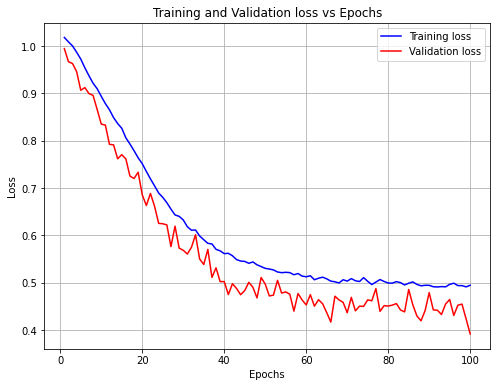

In [144]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(range(1,len(train_losses)+1),train_losses,label="Training loss",color="Blue")
plt.plot(range(1,len(val_losses)+1),val_losses,label="Validation loss",color="Red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss vs Epochs")
plt.legend()
plt.grid()
plt.show()
